# Check effect of spatial-dependence of velocity dispersion 

A reviewer wants us to justify our approximation that $\sigma_v$ is constant.  Here I will compute the result with $\sigma_v(r)$ and see the difference. The effect must be very small - we are looking away from the galactic center where it is well-known that the velocity profile of the galaxy is very flat (this is one of the evidences for DM in the first place!). 

In [1]:
from functools import partial

import numpy as np
import scipy.integrate as integ
import matplotlib.pyplot as plt



In [2]:
def nfw(r, rs, rho_s):
    x = r/rs
    return rho_s/(x*(x + 1)**2)

from Elena's thesis (2212.00125) page 145: $v(r) \propto r^\beta \rho(r)$

In [3]:
def v(r, rsun, vsun, beta, rho):
    return (r/rsun)**beta * (rho(r)/rho(rsun)) * vsun    

from our paper (2310.15395): 

In [4]:
rs = 24 #kpc
rho_s = 0.18 #GeV/cm^3
nfw_us = partial(nfw, rs=rs, rho_s=rho_s)

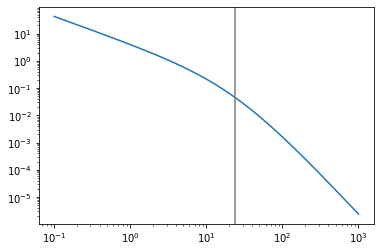

In [5]:
fig, ax = plt.subplots()
r = np.geomspace(0.1, 1e3, 10**3)
ax.plot(r, nfw_us(r))
ax.axvline(rs, color='gray')
ax.set_xscale('log')
ax.set_yscale('log')

$\beta$ is given in Elena's thesis, and using our values for the solar enviroment

In [6]:
beta = 1.9 
rsun=8.1 #kpc
vsun= 160/(3e5) # km/s per c, this is the dispersion \sigma_v

v_us = partial(v, rsun=rsun, vsun=vsun, beta=beta, rho=nfw_us)

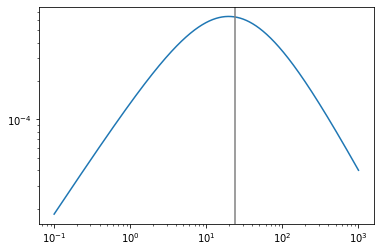

In [7]:
fig, ax = plt.subplots()
r = np.geomspace(0.1, 1e3, 10**3)
ax.plot(r, v_us(r))
ax.axvline(rs, color='gray')
ax.set_xscale('log')
ax.set_yscale('log')

The observed line profile (intrinsic - before convolving with the instrument response) is a Maxwellian from each location in space, but now with different width.  We sum these up.  From each volume element of the galaxy we get:

$$ \frac{df}{d\nu} = \frac{\lambda_0^2}{\sqrt{2 \pi w^2}} e^{-(\lambda - \lambda_0)^2/2w^2} $$
where $w = \lambda_0 \sigma_v(r)$ is a function of space.  The full profile is 
$$ G = \int_\text{los} ds \; \frac{\lambda_0^2}{\sqrt{2 \pi w^2}} e^{-(\lambda - \lambda_0)^2/2w^2} \rho(s) $$
where $W$ is a function of $s$.  We compare to 
$$ G_\text{const} = \frac{\lambda_0^2}{\sqrt{2 \pi w^2}} e^{-(\lambda - \lambda_0)^2/2w^2} \cdot \int_\text{los} ds \rho(s) $$
where now $w$ is fixed to its value in the solar neighboorhood.

Lets normalize $\delta = (\lambda - \lambda_0)/\lambda_0$.  Then
$$ G = \lambda_0 \int_\text{los} ds \; \frac{1}{\sqrt{2 \pi \sigma_v^2}} e^{-\delta^2/2\sigma_v^2} \rho(s) $$

$$ G_\text{const} = \lambda_0 \frac{1}{\sqrt{2 \pi \sigma_v^2}} e^{-\delta^2/2\sigma_v^2} \cdot \int_\text{los} ds \rho(s) $$

we relate r to s and the direction in galactic coordinates latitude $b$ and longitude $l$ as 
$  r^2 = s^2 + r_s^2 - 2 s r_s \cos l \cos b $

Then, dropping the overall $\lambda_0$ we have 

In [8]:
def r_via_s(s, b, l, rsun):
    return np.sqrt(s**2 + rsun**2 - 2*s*rsun*np.cos(np.deg2rad(l))*np.cos(np.deg2rad(b)))

In [9]:
def Dfactor(b, l, rho, rsun):
    integrand = lambda s: rho(r_via_s(s, b, l, rsun))
    out = integ.quad(integrand, 0, np.inf)
    return out[0]

In [10]:
Dfactor_us = partial(Dfactor, rho=nfw_us, rsun=rsun)

Check D-factor from our PRL submission version: D = 3.8 GeV kpc / cm^3 for b = 54.8 degrees and l = 126 degrees. 

In [11]:
b_gnz11, l_gnz11 = 54.8, 126 # degrees

In [12]:
Dus = Dfactor_us(b_gnz11, l_gnz11)

I would expect closer agreement, but carry on for now. 

The velocity distribution in the factorized approximation is 

In [13]:
def fv(delta, sigma_v):
    return np.exp(-0.5*delta**2/sigma_v**2)/(sigma_v*np.sqrt(2*np.pi))

In [14]:
fv_us = partial(fv, sigma_v=vsun)
G_approx_us = lambda d: Dus*fv_us(d)

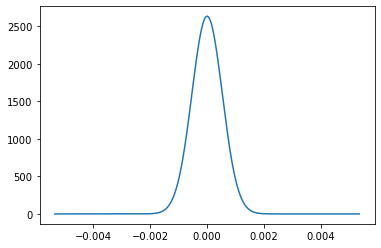

In [15]:
fig, ax = plt.subplots()
d = np.linspace(-10*vsun, 10*vsun, 10**3)
ax.plot(d, G_approx_us(d))

And in the full integrated result is 

In [16]:
def G_full(delta, b, l, rsun, rho, v):
    rho_fixed = lambda s: rho(r_via_s(s, b, l, rsun))
    v_fixed = lambda s: v(r_via_s(s, b, l, rsun))
    delta = np.asarray(delta)
    out = np.zeros(delta.shape)
    for i in range(out.size):
        integrand = lambda s: rho_fixed(s)*fv(delta[i], v_fixed(s))
        out[i] = integ.quad(integrand, 0, np.inf)[0]
    return out
    

In [17]:
G_full_us = partial(G_full, b=b_gnz11, l=l_gnz11, rsun=rsun, rho=nfw_us, v=v_us)

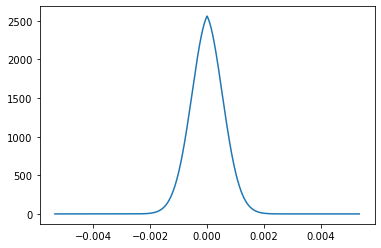

In [18]:
fig, ax = plt.subplots()
d = np.linspace(-10*vsun, 10*vsun, 10**3)
ax.plot(d, G_full_us(d))

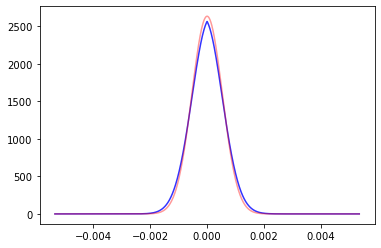

In [19]:
fig, ax = plt.subplots()
d = np.linspace(-10*vsun, 10*vsun, 10**3)
ax.plot(d, G_full_us(d), color='b', alpha=0.8)
ax.plot(d, G_approx_us(d), color='r', alpha=0.4)

The difference here is, relative to the peak values

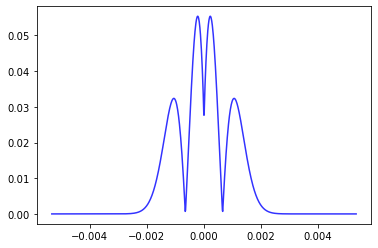

In [20]:
fig, ax = plt.subplots()
d = np.linspace(-10*vsun, 10*vsun, 10**3)
diff = (G_full_us(d) - G_approx_us(d))/G_full_us([0])
ax.plot(d, np.abs(diff), color='b', alpha=0.8)

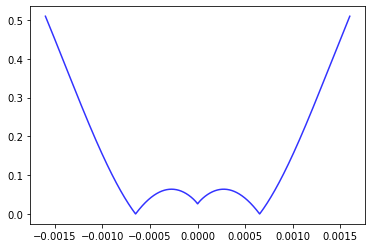

In [21]:
fig, ax = plt.subplots()
d = np.linspace(-3*vsun, 3*vsun, 10**3)
diff = (1 - G_approx_us(d)/G_full_us(d))
ax.plot(d, np.abs(diff), color='b', alpha=0.8)

So this is a 10%, since it will really be only the peak that matters in the search.  But we should also include the instrumental resolution which will lessen this even further. 

In [22]:
sigma_res = (1.4 * 1e-3)/(2*np.sqrt(2*np.log(2))) # micron
lambda_0 = 1.9 # micron

In [23]:
sigma_withinst = np.sqrt(vsun**2 + sigma_res**2/lambda_0**2)
print(sigma_res/lambda_0)
print(vsun)
print(sigma_withinst)

0.00031290803168505967
0.0005333333333333334
0.0006183493193474565


In [24]:
fv_us_withinst = partial(fv, sigma_v=sigma_withinst)
G_approx_withinst = lambda d: Dus*fv_us_withinst(d)

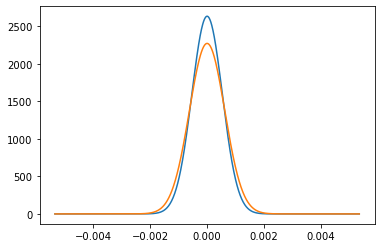

In [25]:
fig, ax = plt.subplots()
d = np.linspace(-10*vsun, 10*vsun, 10**3)
ax.plot(d, G_approx_us(d))
ax.plot(d, G_approx_withinst(d))

In [26]:
def G_full_withinst(delta, b, l, rsun, rho, v, sigma_inst):
    rho_fixed = lambda s: rho(r_via_s(s, b, l, rsun))
    v_fixed = lambda s: np.sqrt(v(r_via_s(s, b, l, rsun))**2 + sigma_inst**2)
    delta = np.asarray(delta)
    out = np.zeros(delta.shape)
    for i in range(out.size):
        integrand = lambda s: rho_fixed(s)*fv(delta[i], v_fixed(s))
        out[i] = integ.quad(integrand, 0, np.inf)[0]
    return out

In [27]:
G_full_us_withinst = partial(G_full_withinst, b=b_gnz11, l=l_gnz11, 
                             rsun=rsun, rho=nfw_us, v=v_us, 
                             sigma_inst=(sigma_res/lambda_0))

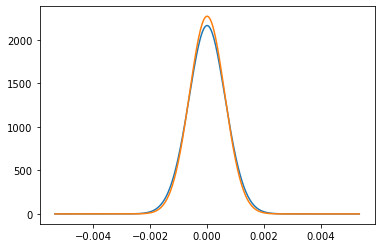

In [28]:
fig, ax = plt.subplots()
d = np.linspace(-10*vsun, 10*vsun, 10**3)
ax.plot(d, G_full_us_withinst(d))
ax.plot(d, G_approx_withinst(d))

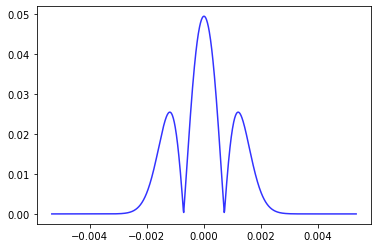

In [29]:
fig, ax = plt.subplots()
d = np.linspace(-10*vsun, 10*vsun, 10**3)
diff = (G_full_us_withinst(d) - G_approx_withinst(d))/G_full_us_withinst([0])
ax.plot(d, np.abs(diff), color='b', alpha=0.8)

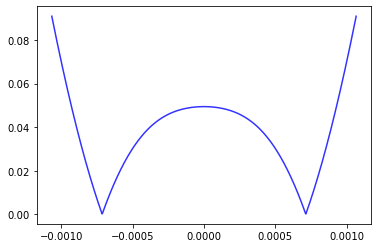

In [30]:
fig, ax = plt.subplots()
d = np.linspace(-2*vsun, 2*vsun, 10**3)
diff = (1 - G_approx_withinst(d)/G_full_us_withinst(d))
ax.plot(d, np.abs(diff), color='b', alpha=0.8)

In [31]:
np.exp(-0.5*4)

0.1353352832366127